In [5]:
from games.kuhn.kuhn3 import KuhnPoker3
from agents.counterfactualregret import CounterFactualRegret
from agents.agent_random import RandomAgent
from agents.mcts import MonteCarloTreeSearch
from agents.minimax import MiniMax
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def Run(agents, verbose = True, n=10):
    categories = ["Ganados", "Empatados", "Perdidos"]
    results = {
        k: [0, 0, 0] for k, _ in agents.items()
    }
    sum_rewards = {
        k: 0 for k, _ in agents.items()
    }

    for i in range(n):
        # Se crea nueva instancia de juego para probar distintas posiciones
        game = KuhnPoker3()
        game.reset()
        if verbose:
            print(f"Initial Agent: {game.agent_selection} ({agents[game.agent_selection][0]})")
        while not game.game_over():
            game.render()
            agents[game.agent_selection][1].game = game
            action = agents[game.agent_selection][1].action()
            if verbose:
                print(f"Agent {game.agent_selection} ({agents[game.agent_selection][0]}) plays action {action}")
            game.step(action=action)
        game.render()
        if game.truncated():
            if verbose:
                print("Game was truncated")
        for agent in agents:
            if verbose:
                print(f"Reward agent {agent} ({agents[agent][0]}): {game.reward(agent)}")

        winner = max(game.rewards, key=game.rewards.get)

        if verbose:
            if winner is None:
                print(f"Drawn game")
            else:
                print(f"The winner is: {winner} ({agents[winner][0]})")

        for agent in agents:
            sum_rewards[agent] += game.reward(agent)
            if winner is None:
                results[agent][1] += 1
            elif winner == agent:
                results[agent][0] += 1
            else:
                results[agent][2] += 1

    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax = axes[0]
    x = np.arange(len(categories))
    bar_width = 0.35
    agent_ids = list(agents)

    ax.bar(x - bar_width, results[agent_ids[0]], bar_width, label=agents[agent_ids[0]][0])
    ax.bar(x, results[agent_ids[1]], bar_width, label=agents[agent_ids[1]][0])
    ax.bar(x + bar_width, results[agent_ids[2]], bar_width, label=agents[agent_ids[2]][0])

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Cantidad')
    ax.set_title(f"Comparación de resultados sobre {n} juegos")
    ax.legend()

    ax = axes[1]
    x = np.arange(len(agents))
    bar_width = 0.35
    agent_ids = list(agents)

    default_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    bar_colors    = default_cycle[:3]

    ax.bar([agents[k][0] for k in sum_rewards.keys()], sum_rewards.values(), color=bar_colors)
    ax.set_ylabel('Recompensa acumulada')
    ax.set_title(f"Comparación de resultados sobre {n} juegos")

    plt.show()

In [7]:
g = KuhnPoker3()

In [8]:
cfr = CounterFactualRegret(game=g, agent=g.agents[1])
cfr.train(100000)

### MCTS vs CFR

Initial Agent: agent_1 (CFR)
agent_0 J 
agent_1 K 
agent_2 A 
Agent agent_1 (CFR) plays action 0
agent_0 J p
agent_1 K p
agent_2 A p
Agent agent_2 (MCTS_2) plays action 1
agent_0 J pb
agent_1 K pb
agent_2 A pb
Agent agent_0 (MCTS_1) plays action 0
agent_0 J pbp
agent_1 K pbp
agent_2 A pbp
Agent agent_1 (CFR) plays action 1
agent_0 J pbpb
agent_1 K pbpb
agent_2 A pbpb
Reward agent agent_0 (MCTS_1): -1
Reward agent agent_1 (CFR): -2
Reward agent agent_2 (MCTS_2): 3
The winner is: agent_2 (MCTS_2)
Initial Agent: agent_1 (CFR)
agent_0 A 
agent_1 Q 
agent_2 J 
Agent agent_1 (CFR) plays action 0
agent_0 A p
agent_1 Q p
agent_2 J p
Agent agent_2 (MCTS_2) plays action 1
agent_0 A pb
agent_1 Q pb
agent_2 J pb
Agent agent_0 (MCTS_1) plays action 1
agent_0 A pbb
agent_1 Q pbb
agent_2 J pbb
Agent agent_1 (CFR) plays action 0
agent_0 A pbbp
agent_1 Q pbbp
agent_2 J pbbp
Reward agent agent_0 (MCTS_1): 3
Reward agent agent_1 (CFR): -1
Reward agent agent_2 (MCTS_2): -2
The winner is: agent_0 (MCTS_1)


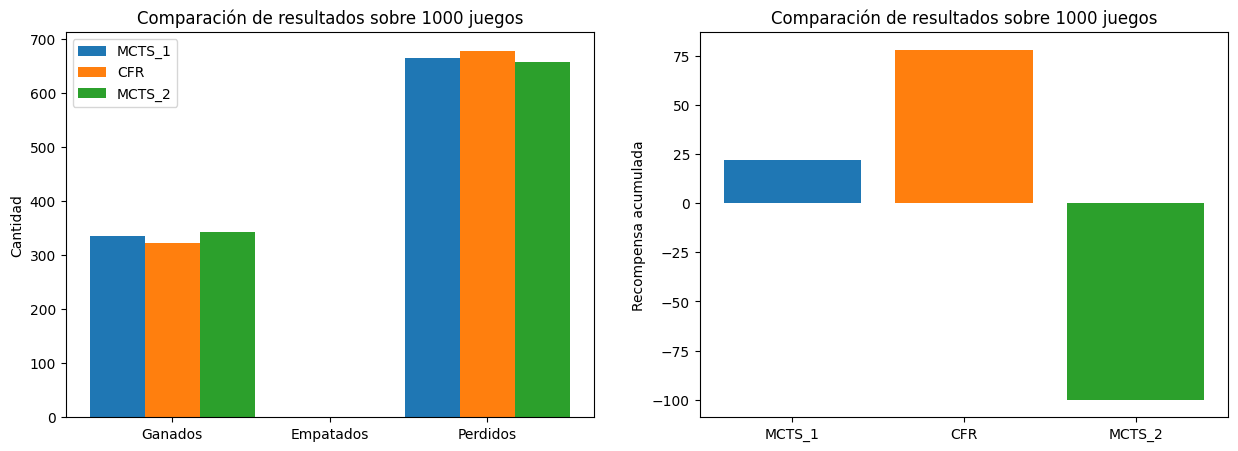

In [12]:
Run({
    g.agents[0]: ("MCTS_1", MonteCarloTreeSearch(game=g, agent=g.agents[0], max_depth=0)),
    g.agents[1]: ("CFR", cfr),
    g.agents[2]: ("MCTS_2", MonteCarloTreeSearch(game=g, agent=g.agents[2], max_depth=0, rollouts=100))
}, n=1000)

### MCTS vs MinMax vs CFR

Initial Agent: agent_1 (CFR)
agent_0 A 
agent_1 J 
agent_2 Q 
Agent agent_1 (CFR) plays action 0
agent_0 A p
agent_1 J p
agent_2 Q p
Agent agent_2 (MinMax) plays action 0
agent_0 A pp
agent_1 J pp
agent_2 Q pp
Agent agent_0 (MCTS) plays action 1
agent_0 A ppb
agent_1 J ppb
agent_2 Q ppb
Agent agent_1 (CFR) plays action 0
agent_0 A ppbp
agent_1 J ppbp
agent_2 Q ppbp
Agent agent_2 (MinMax) plays action 0
agent_0 A ppbpp
agent_1 J ppbpp
agent_2 Q ppbpp
Reward agent agent_0 (MCTS): 2
Reward agent agent_1 (CFR): -1
Reward agent agent_2 (MinMax): -1
The winner is: agent_0 (MCTS)
Initial Agent: agent_2 (MinMax)
agent_0 J 
agent_1 A 
agent_2 Q 
Agent agent_2 (MinMax) plays action 0
agent_0 J p
agent_1 A p
agent_2 Q p
Agent agent_0 (MCTS) plays action 0
agent_0 J pp
agent_1 A pp
agent_2 Q pp
Agent agent_1 (CFR) plays action 1
agent_0 J ppb
agent_1 A ppb
agent_2 Q ppb
Agent agent_2 (MinMax) plays action 0
agent_0 J ppbp
agent_1 A ppbp
agent_2 Q ppbp
Agent agent_0 (MCTS) plays action 0
agent_0 J 

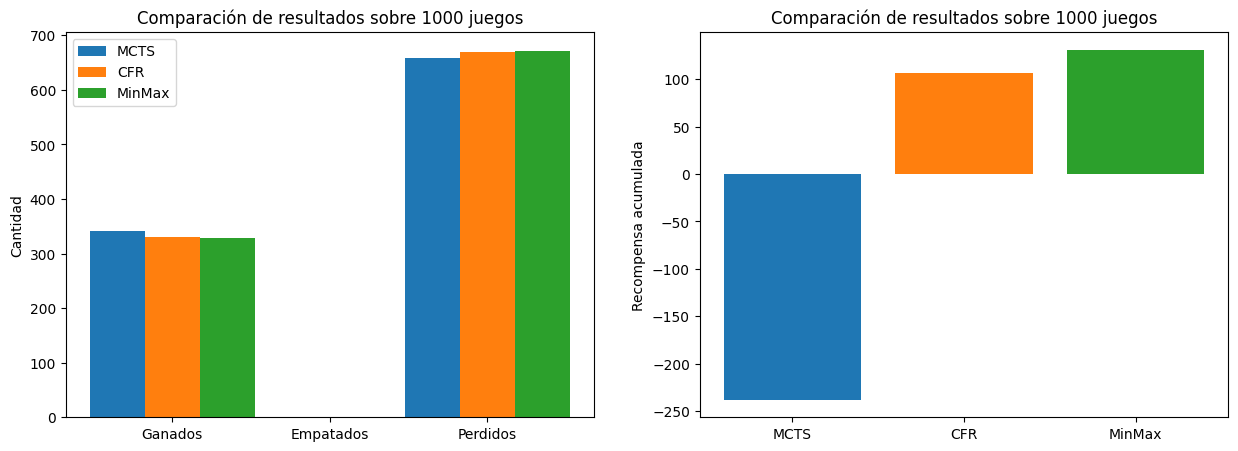

In [10]:
Run({
    g.agents[0]: ("MCTS", MonteCarloTreeSearch(game=g, agent=g.agents[0], max_depth=0, rollouts=100)),
    g.agents[1]: ("CFR", cfr),
    g.agents[2]: ("MinMax", MiniMax(game=g, agent=g.agents[2]))
}, n=1000)